In [1]:
!nvidia-smi

Sun Dec 26 04:59:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

!pip install torchmetrics
import torchmetrics
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import os
import io
import cv2
import numpy as np
import pandas as pd
import albumentations as A
import csv
import random
import matplotlib.pyplot as plt

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [9]:
train_number = 50000
val_number = 10000
test_number = 10000
#by set this param you can make your dataset bigger---------for no change in dataset size set it 1
multiple_train_param = 5
multiple_val_param = 5
multiple_test_param = 5

In [8]:
transform = A.Compose([
                      #  A.HorizontalFlip(p=0.9),
                      #  A.ShiftScaleRotate(p=0.9),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                       transforms.ToTensor(),
                      #  A.RandomBrightness(p=0.3),
                       ])

mnist = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor(),)

mnist_train, mnist_val = torch.utils.data.random_split(mnist, [train_number, val_number])

mnist_test = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor(),)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
loaders1 = {
    'train' : torch.utils.data.DataLoader(mnist_train, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),

    'val' : torch.utils.data.DataLoader(mnist_val, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),       
    
    'test'  : torch.utils.data.DataLoader(mnist_test, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders1

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f252ce45e50>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f252ce45f90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f2520bc3050>}

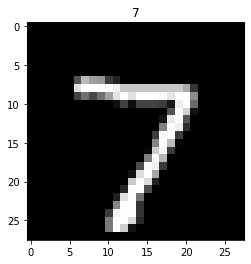

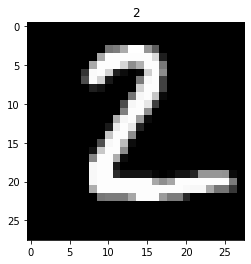

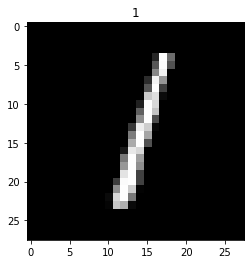

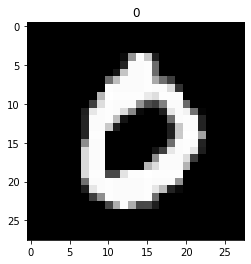

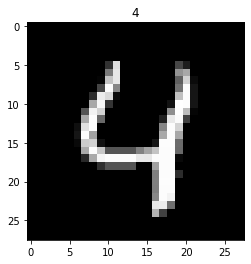

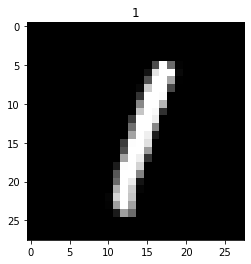

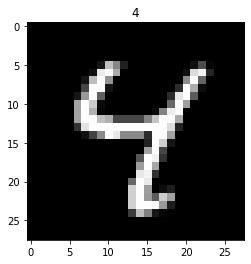

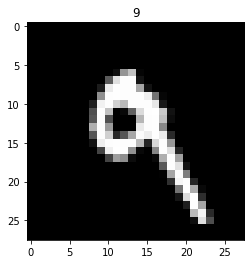

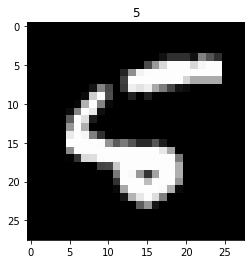

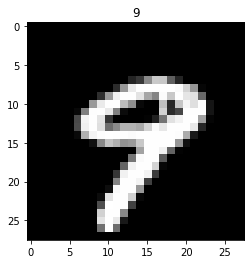

In [11]:
for i in range(10):
  plt.imshow(mnist_test.data[i], cmap='gray')
  plt.title(f"{mnist_test.targets[i]}")
  plt.show()

In [12]:
def dataset_process(train_val_test, writer1 , multiple_dataset_param=1):
  os.makedirs(f"mnist/{train_val_test}/GT", exist_ok=True)
  os.makedirs(f"mnist/{train_val_test}/img", exist_ok=True)

  for batch_idx, (inputs, targets) in enumerate(loaders1[train_val_test]):

    image = inputs[0].permute(1, 2, 0).numpy()
    image_indx = multiple_dataset_param * batch_idx  

    if batch_idx % 10000 == 0:
        print(batch_idx)
#         break
    for index1 in range(multiple_dataset_param):
      angle = random.randint(0, 360)
      transform = A.Compose([
                          A.ShiftScaleRotate(rotate_limit=[angle, angle], border_mode=cv2.BORDER_CONSTANT, p = 1),
                            ])
      transformed = transform(image=image)

      image_loc = f"mnist/{train_val_test}/GT/GT{image_indx+index1}.pt"
      GT_loc = f"mnist/{train_val_test}/img/img{image_indx+index1}.pt"
      writer1.writerow([image_indx+index1, image_loc, GT_loc, targets[0].item(), angle])
      torch.save(np.transpose(image, (2, 0, 1)), GT_loc)
      torch.save(np.transpose(transformed['image'], (2, 0, 1)) , image_loc)

In [ ]:
# !rm -rf 'mnist'

In [13]:
def dataset_maker(train_val_test, multiple_train_param):
  f = open(f'./mnist_{train_val_test}.csv', 'w')
  writer = csv.writer(f)
  writer.writerow(['index', 'img_add', 'GT_add','class', 'angle'])
  dataset_process(train_val_test,writer, multiple_train_param)
  f.close()

In [14]:
dataset_maker('train', multiple_train_param)
dataset_maker('val', multiple_val_param)
dataset_maker('test', multiple_test_param)


0
10000
20000
30000
40000
0
0


In [19]:
pd.read_csv('mnist_val.csv')

,index,img_add,GT_add,class,angle
0,0,mnist/val/GT/GT0.pt,mnist/val/img/img0.pt,7,118
1,1,mnist/val/GT/GT1.pt,mnist/val/img/img1.pt,7,211
2,2,mnist/val/GT/GT2.pt,mnist/val/img/img2.pt,7,257
3,3,mnist/val/GT/GT3.pt,mnist/val/img/img3.pt,7,116
4,4,mnist/val/GT/GT4.pt,mnist/val/img/img4.pt,7,74
...,...,...,...,...,...
49995,49995,mnist/val/GT/GT49995.pt,mnist/val/img/img49995.pt,1,318
49996,49996,mnist/val/GT/GT49996.pt,mnist/val/img/img49996.pt,1,318
49997,49997,mnist/val/GT/GT49997.pt,mnist/val/img/img49997.pt,1,135
49998,49998,mnist/val/GT/GT49998.pt,mnist/val/img/img49998.pt,1,101


In [16]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data_frame, is_google_colab=False):
        'Initialization'
        self.angle = list(data_frame['angle'])
        self.img_add = list(data_frame['img_add'])
        self.GT_add = list(data_frame['GT_add'])
        self.class_ = list(data_frame['class'])
        #if you run this on google colab set this True
        self.is_google_colab = is_google_colab
        
        self.len_ =  len(list(data_frame['index']))



  def __len__(self):
        'Denotes the total number of samples'
        return self.len_


  def __getitem__(self, index):
        # Load data and get lab
        if self.is_google_colab:
          pre = 'content/'
        else:
          pre = './'
        X_add = pre+str(self.img_add[index])
        Y_add = pre+str(self.GT_add[index])
        X = torch.load(X_add)
        Y = torch.load(Y_add)
        extra_params = [self.angle[index], self.class_[index]]

        return X, Y, extra_params

In [20]:
#if you run this on google colab set this True
is_google_colab = False
mnist_train_info = pd.read_csv('mnist_train.csv')
train_data = Dataset(mnist_train_info, is_google_colab)

mnist_val_info = pd.read_csv('mnist_val.csv')
val_data = Dataset(mnist_val_info, is_google_colab)

mnist_test_info = pd.read_csv('mnist_val.csv')
test_data = Dataset(mnist_test_info, is_google_colab)

In [21]:
print(len(train_data), len(val_data), len(test_data))

250000 50000 50000


In [41]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=150, 
                                          shuffle=True, 
                                          num_workers=0),

    'val' : torch.utils.data.DataLoader(val_data, 
                                          batch_size=200, 
                                          shuffle=True, 
                                          num_workers=0),       
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=0),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f24fe715490>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f24fe715a10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f24fe715650>}

In [23]:
inp, res, params = next(iter(loaders['val']))
angles = params[0]
classes = params[1]

In [24]:
def plot_image(inp, res, angles=None, classes=None, numer=4):
  for i in range(numer):
    plt.imshow(inp[i].permute(1,2,0)[:,:, 0], cmap='gray')
    if angles is not None:
      plt.title(angles[i].item())
    plt.show()
    plt.imshow(res[i].permute(1,2,0)[:,:, 0], cmap='gray')
    plt.show()

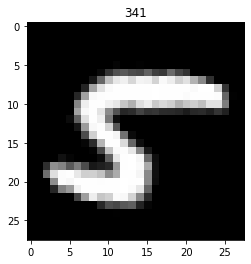

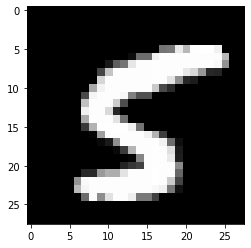

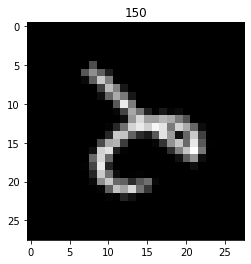

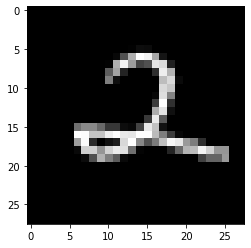

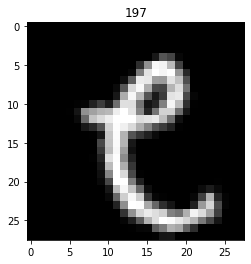

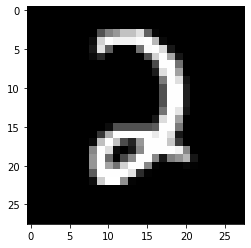

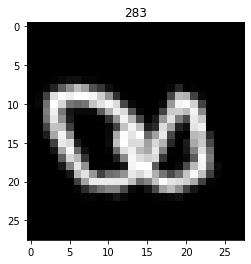

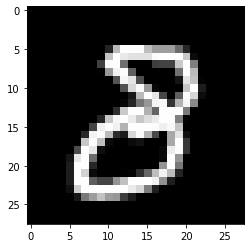

In [25]:
plot_image(inp, res, angles)

In [26]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('MNIST')

In [27]:
#sometimes logger.info doesn't work. please make sure this command orint info
logger.info('This is an info message')

In [29]:
class DoubleConv(nn.Module):
    #(convolution => [BN] => ReLU) * 2

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    # Downscaling with maxpool then double conv
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    #Upscaling then double conv

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [30]:
class MNIST_Net(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(MNIST_Net, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [31]:
net = MNIST_Net(1, 1).to(device=device)

In [32]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

17261825

In [33]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [34]:
criterion(res.to(device), net(inp.to(device)))

tensor(0.3919, device='cuda:0', grad_fn=<MseLossBackward>)

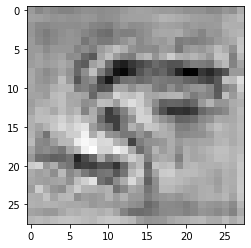

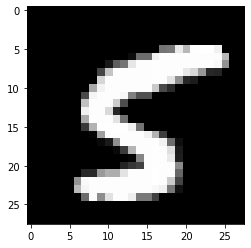

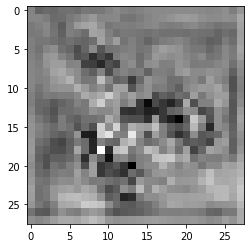

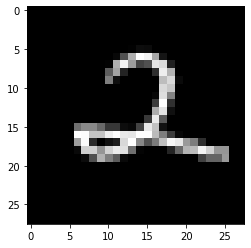

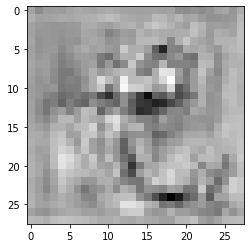

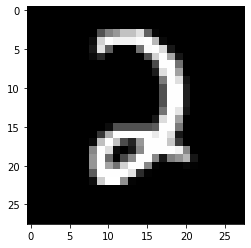

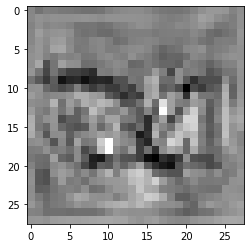

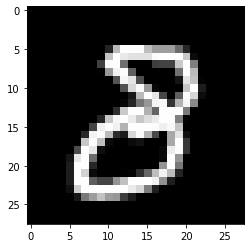

In [35]:
y = torch.tensor( net(inp.to(device)).cpu().detach().numpy() )
plot_image(y, res)

In [36]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [48]:
# Training
def train(epoch, logger_period=500, val_logger_period=450):
    net.train()
    # train_loss_total = AverageMeter()
    for batch_idx, (inputs, targets, extra_params) in enumerate(loaders['train']):
        inputs, targets, = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        # train_loss_total.update(loss)
        loss.backward()
        optimizer.step()
        if batch_idx % logger_period == 0 and batch_idx > 0:
            print(f"Epoch:{epoch} Batch: {batch_idx} Train_Loss: {loss.item():.5}")
#         if batch_idx == 10:
#           break

    net.eval()
    # val_loss_total = AverageMeter()
    for batch_idx, (inputs, targets, extra_params) in enumerate(loaders['val']):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        # val_loss_total.update(loss)
        if batch_idx % val_logger_period == 0 and batch_idx > 0 :
            print(f"Epoch:{epoch} Batch: {batch_idx} Val_Loss: {loss.item():.5}")
      
    torch.save(net.state_dict(), 'saved_model.pth')
    torch.save({
    'state_dict': net.state_dict(),
    'optimizer' : optimizer.state_dict(),
    }, 'MNIST_Net.pth.tar')



def test(epoch, checkpoint=0):
    net = MNIST_Net(1, 1).to(device=device)
    checkpoint = torch.load('MNIST_Net.pth.tar')
    net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    net.eval()
    loss_total = AverageMeter()
    with torch.no_grad():
        for batch_idx, (inputs, targets, extra_params) in enumerate(loaders['test']):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss_total.update(loss)


        print(f'Test:  Epoch:{epoch} Loss:{loss_total.avg:.4}')
        print()
    


In [39]:
train(0, 50)
test(0)

Epoch:0 Batch: 50 Train_Loss: 0.066331
Epoch:0 Batch: 100 Train_Loss: 0.063185
Epoch:0 Batch: 150 Train_Loss: 0.062571
Epoch:0 Batch: 200 Train_Loss: 0.060478
Epoch:0 Batch: 250 Train_Loss: 0.057139
Epoch:0 Batch: 300 Train_Loss: 0.056875
Epoch:0 Batch: 350 Train_Loss: 0.056707
Epoch:0 Batch: 400 Train_Loss: 0.055298
Epoch:0 Batch: 450 Train_Loss: 0.05452
Epoch:0 Batch: 500 Train_Loss: 0.050617
Epoch:0 Batch: 550 Train_Loss: 0.049032
Epoch:0 Batch: 600 Train_Loss: 0.049853
Epoch:0 Batch: 650 Train_Loss: 0.04819
Epoch:0 Batch: 700 Train_Loss: 0.044832
Epoch:0 Batch: 750 Train_Loss: 0.049728
Epoch:0 Batch: 800 Train_Loss: 0.045915
Epoch:0 Batch: 850 Train_Loss: 0.048289
Epoch:0 Batch: 900 Train_Loss: 0.046542
Epoch:0 Batch: 950 Train_Loss: 0.046643
Epoch:0 Batch: 1000 Train_Loss: 0.046793
Epoch:0 Batch: 1050 Train_Loss: 0.045687
Epoch:0 Batch: 1100 Train_Loss: 0.04757
Epoch:0 Batch: 1150 Train_Loss: 0.046973
Epoch:0 Batch: 1200 Train_Loss: 0.041963
Epoch:0 Batch: 1250 Train_Loss: 0.04326

In [49]:
criterion(res.to(device), net(inp.to(device)))

tensor(0.0421, device='cuda:0', grad_fn=<MseLossBackward>)

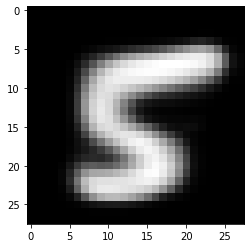

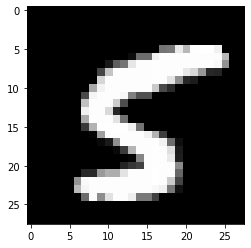

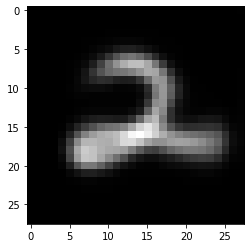

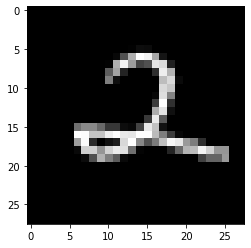

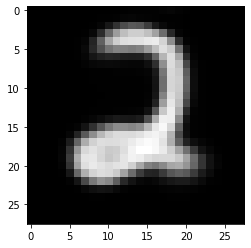

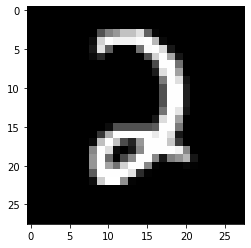

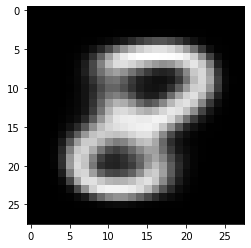

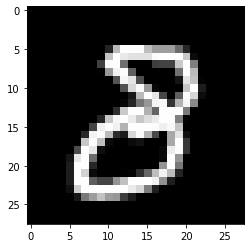

In [50]:
y = torch.tensor( net(inp.to(device)).cpu().detach().numpy() )
plot_image(y, res)

In [52]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.65)

In [53]:
for i in range(20):
    print(f"Learning Rate For Epoch {i}: {optimizer.param_groups[0]['lr']:.3}")
    train(i, 800, 200)
    scheduler.step()

Learning Rate For Epoch 0: 0.1
Epoch:0 Batch: 800 Train_Loss: 0.028885
Epoch:0 Batch: 1600 Train_Loss: 0.031178
Epoch:0 Batch: 200 Val_Loss: 0.038468
Learning Rate For Epoch 1: 0.1
Epoch:1 Batch: 800 Train_Loss: 0.027477
Epoch:1 Batch: 1600 Train_Loss: 0.025521
Epoch:1 Batch: 200 Val_Loss: 0.037653
Learning Rate For Epoch 2: 0.1
Epoch:2 Batch: 800 Train_Loss: 0.024519
Epoch:2 Batch: 1600 Train_Loss: 0.024824
Epoch:2 Batch: 200 Val_Loss: 0.034161
Learning Rate For Epoch 3: 0.065
Epoch:3 Batch: 800 Train_Loss: 0.021748
Epoch:3 Batch: 1600 Train_Loss: 0.020724
Epoch:3 Batch: 200 Val_Loss: 0.026584
Learning Rate For Epoch 4: 0.065
Epoch:4 Batch: 800 Train_Loss: 0.023222
Epoch:4 Batch: 1600 Train_Loss: 0.022622
Epoch:4 Batch: 200 Val_Loss: 0.028632
Learning Rate For Epoch 5: 0.065
Epoch:5 Batch: 800 Train_Loss: 0.022299
Epoch:5 Batch: 1600 Train_Loss: 0.023207
Epoch:5 Batch: 200 Val_Loss: 0.029779
Learning Rate For Epoch 6: 0.0423
Epoch:6 Batch: 800 Train_Loss: 0.020664
Epoch:6 Batch: 1600 

In [54]:
criterion(res.to(device), net(inp.to(device)))

tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward>)

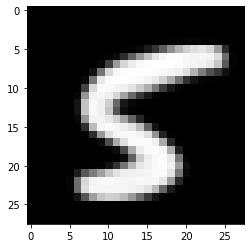

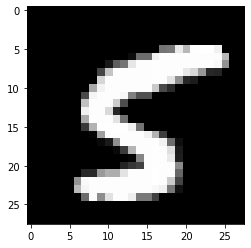

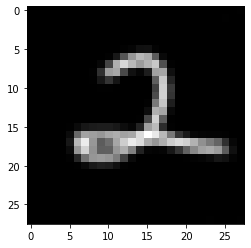

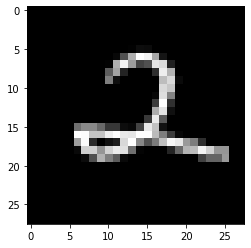

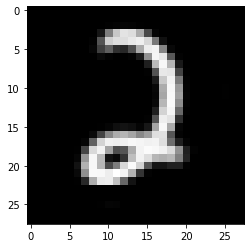

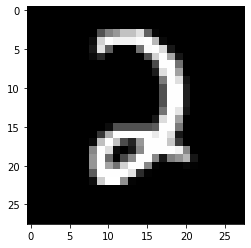

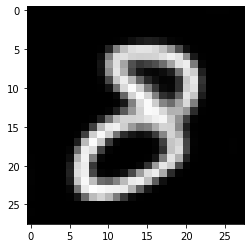

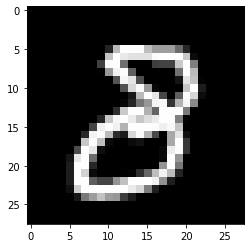

In [55]:
y = torch.tensor( net(inp.to(device)).cpu().detach().numpy() )
plot_image(y, res)

In [56]:
test(100)

Test:  Epoch:100 Loss:0.01629



In [ ]:
def better_pic(input1):
    for k in range(10):
        min1 = np.inf
        max1 = -1 * np.inf
        for i in range(28):
            for j in range(28):
                if input1[k][0][i][j]  < min1:
                    min1 = input1[0][0][i][j]
                if input1[k][0][i][j]  > max1:
                    max1 = input1[0][0][i][j]
        mid1 = (min1 + max1)/2
        print(mid1, min1, max1)
        for i in range(28):
            for j in range(28):
                if input1[k][0][i][j]  < (mid1+min1)/2:
                    input1[k][0][i][j] = 0
    #             elif input1[k][0][i][j]  > (mid1+max1)/1.5:
    #                 input1[k][0][i][j] = 1
    return input1